In [89]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

## Importing the augmented dataset:
*   `dataset_augmentation.ipynb` - Loads the original Brain Tumor Dataset (3064 T1-Weighted MRI images) and augments the dataset using techniques such as rotating, mirroring, flipping over an axis and salting.
*   `augmented_images.npz` - Contains the full dataset after augmentation (15320 images and 15320 labels)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# images_path = '../dataset/augmented_images.npz'
images_path = '/content/gdrive/MyDrive/augmented_images.npz'

In [4]:
with np.load(images_path) as data:
    
  images = data['images']
  labels = data['labels']
  print('images: ', images.shape)
  print('labels:', labels.shape)

images:  (15320, 128, 128)
labels: (15320,)


## Reformatting the data
*   reformat into a tensorflow-friendly shape
*   shuffle the data
*   split the dataset into train, validation and test dataset with the following ratio: 80, 10, 10


In [5]:
num_labels = 3
num_channels = 1 # MRI images are grayscale
image_size = 128

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

images, labels = reformat(images, labels)
print('images:', images.shape)
print('labels:', labels.shape)

images: (15320, 128, 128, 1)
labels: (15320, 3)


In [6]:
# Shufling the two numpy arrays in unison
from sklearn import utils
images, labels = utils.shuffle(images,labels)

In [7]:
train_dataset, remaining_dataset, train_labels, remaining_labels = train_test_split(images, labels, train_size=0.8)
valid_dataset,test_dataset, valid_labels, test_labels = train_test_split(remaining_dataset, remaining_labels, test_size=0.5)

print('Training set:', train_dataset.shape, train_labels.shape)
print('Validation set:', valid_dataset.shape, valid_labels.shape)
print('Test set:', test_dataset.shape, test_labels.shape)

Training set: (12256, 128, 128, 1) (12256, 3)
Validation set: (1532, 128, 128, 1) (1532, 3)
Test set: (1532, 128, 128, 1) (1532, 3)


## Defining the brain tumor classification model


In [11]:
# Architecture:
# Input: 128 x 128 x 1
# Conv1: 128 x 128 x 16
# MaxPool1: 64 x 64 x 16
# Conv2: 64 x 64 x 32
# MaxPool2: 32 x 32 x 32
# Conv3: 32 x 32 x 64
# MaxPool3: 16 x 16 x 64
# FC: 16 * 16 * 64 , 64
# Output: 64, 3

filter_size = 3
depth_conv1 = 16
depth_conv2 = 32
depth_conv3 = 64

weights = {
    'wc1' : tf.Variable(tf.random.truncated_normal([filter_size, filter_size, num_channels, depth_conv1], stddev=0.1)),
    'wc2' : tf.Variable(tf.random.truncated_normal([filter_size, filter_size, depth_conv1, depth_conv2], stddev=0.1)),
    'wc3' : tf.Variable(tf.random.truncated_normal([filter_size, filter_size, depth_conv2, depth_conv3], stddev=0.1)),
    'wfc' : tf.Variable(tf.random.truncated_normal([16 * 16 * depth_conv3, depth_conv3], stddev = 0.1)),
    'wout': tf.Variable(tf.random.truncated_normal([depth_conv3, num_labels], stddev = 0.1)),
}

biases = {
    'bc1' : tf.Variable(tf.constant(1.0, shape=[depth_conv1])),
    'bc2' : tf.Variable(tf.constant(1.0, shape=[depth_conv2])),
    'bc3' : tf.Variable(tf.constant(1.0, shape=[depth_conv3])),
    'bfc' : tf.Variable(tf.constant(1.0, shape=[depth_conv3])),
    'bout': tf.Variable(tf.constant(1.0, shape=[num_labels])),
}


In [12]:
# Wrapper functions for the convolutional and max pooling layers
def conv2d(x, W, b, stride=1):
  x = tf.nn.conv2d(x, W, strides=[1,stride,stride,1], padding='SAME')
  x = tf.nn.bias_add(x, b)
  return tf.nn.relu(x)

def maxpool(x, k = 2):
  return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')


In [13]:
def braintumor_classification_model(data):
  conv_layer1 = conv2d(data, weights['wc1'], biases['bc1'])
  conv_layer1 = maxpool(conv_layer1)

  conv_layer2 = conv2d(conv_layer1, weights['wc2'], biases['bc2'])
  conv_layer2 = maxpool(conv_layer2)

  conv_layer3 = conv2d(conv_layer2, weights['wc3'], biases['bc3'])
  conv_layer3 = maxpool(conv_layer3)

  conv_layer3_shape = conv_layer3.get_shape().as_list()
  fc_layer = tf.reshape(conv_layer3, [conv_layer3_shape[0], conv_layer3_shape[1] * conv_layer3_shape[2] * conv_layer3_shape[3]])
  fc_layer = tf.add(tf.matmul(fc_layer, weights['wfc']), biases['bfc'])
  fc_layer = tf.nn.relu(fc_layer)

  output_layer = tf.add(tf.matmul(fc_layer, weights['wout']), biases['bout'])
  return output_layer

In [14]:
def compute_loss(labels, logits):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

In [15]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

### Training

In [16]:
batch_size = 64
train_tf_dataset = tf.data.Dataset.from_tensor_slices(
    (train_dataset, train_labels)).shuffle(1000).batch(batch_size)

In [17]:
num_batches_val = 4 
batch_size_val = int(len(valid_dataset) / num_batches_val) # 4 batches, 383 examples in each batch
print("Num of examples in one batch - validation dataset:", batch_size_val)
valid_tf_dataset = tf.data.Dataset.from_tensor_slices((valid_dataset, valid_labels)).batch(batch_size_val)

Num of examples in one batch - validation dataset: 383


In [18]:
epochs = 40
display_step = 100
learning_rate = 0.001

optimizer = tf.keras.optimizers.SGD(learning_rate)

for epoch in range(epochs):

    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (batch_x_train, batch_y_train) in enumerate(train_tf_dataset, 1):

        with tf.GradientTape() as g:
          logits = braintumor_classification_model(batch_x_train)
          loss = compute_loss(batch_y_train, logits)

        # Optimizer.
        optimizer.minimize(loss, g.watched_variables(), tape=g)
        
        # Predictions for the training and validation data.
        if step % display_step == 0:
          train_prediction = tf.nn.softmax(logits)
          train_acc = accuracy(train_prediction, batch_y_train)

          valid_acc = 0

          for (batch_x_val, batch_y_val) in valid_tf_dataset:  
              valid_prediction = tf.nn.softmax(braintumor_classification_model(batch_x_val))
              valid_acc += accuracy(valid_prediction, batch_y_val)
          
          print("step: %i, loss: %f, train acc: %f, validation acc: %f" % (step, loss, train_acc, valid_acc / num_batches_val))
          print("Seen so far: %s samples" % (step * batch_size))


Start of epoch 0
step: 100, loss: 0.941478, train acc: 57.812500, validation acc: 58.028721
Seen so far: 6400 samples

Start of epoch 1
step: 100, loss: 0.785233, train acc: 60.937500, validation acc: 61.422977
Seen so far: 6400 samples

Start of epoch 2
step: 100, loss: 0.687381, train acc: 67.187500, validation acc: 65.013055
Seen so far: 6400 samples

Start of epoch 3
step: 100, loss: 0.705952, train acc: 59.375000, validation acc: 69.321149
Seen so far: 6400 samples

Start of epoch 4
step: 100, loss: 0.518196, train acc: 78.125000, validation acc: 73.890339
Seen so far: 6400 samples

Start of epoch 5
step: 100, loss: 0.557814, train acc: 73.437500, validation acc: 75.130548
Seen so far: 6400 samples

Start of epoch 6
step: 100, loss: 0.481842, train acc: 78.125000, validation acc: 76.631854
Seen so far: 6400 samples

Start of epoch 7
step: 100, loss: 0.427701, train acc: 79.687500, validation acc: 74.934726
Seen so far: 6400 samples

Start of epoch 8
step: 100, loss: 0.643305, tra

### Accuracy on the whole training set

In [19]:
train_acc = 0
num_batches_train = 0
for (batch_x, batch_y) in train_tf_dataset:  
    num_batches_train += 1
    train_prediction = tf.nn.softmax(braintumor_classification_model(batch_x))
    train_acc += accuracy(train_prediction, batch_y)
 
print("Train accuracy: ", train_acc / num_batches_train)

Train accuracy:  85.97005208333333


### Accuracy on validation dataset

In [20]:
valid_acc = 0

for (batch_x, batch_y) in valid_tf_dataset:  
    valid_prediction = tf.nn.softmax(braintumor_classification_model(batch_x))
    valid_acc += accuracy(valid_prediction, batch_y)
 
print("Validation accuracy: ", valid_acc / num_batches_val)

Validation accuracy:  86.42297650130548


### Accuracy and confusion matrix on test dataset

In [21]:
num_batches_test = 4 
batch_size_test = int(len(test_dataset) / num_batches_test) # 4 batches, 383 examples in each batch
print("Num of examples in one batch:", batch_size_test)
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_dataset, test_labels)).batch(batch_size_test)

Num of examples in one batch: 383


In [104]:
test_acc = 0
confusion_matrix = tf.Variable(tf.constant(0, shape=[num_labels,num_labels]))

for (batch_x, batch_y) in test_tf_dataset:  
    test_prediction = tf.nn.softmax(braintumor_classification_model(batch_x))
    test_acc += accuracy(test_prediction, batch_y)

    confusion_matrix_batch = tf.math.confusion_matrix(labels = tf.argmax(batch_y, axis=1), predictions = tf.argmax(test_prediction,axis=1), num_classes = 3)
    confusion_matrix = tf.math.add(confusion_matrix, confusion_matrix_batch)
 
print("Test accuracy: ", test_acc / num_batches_test)

Test accuracy:  85.37859007832898


### Visualisation of the confusion matrix

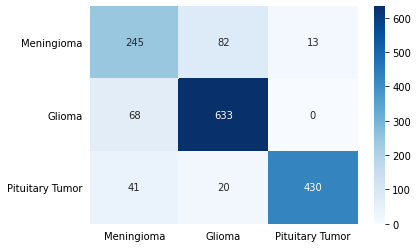

In [112]:
# Real Values
categories = ['Meningioma', 'Glioma', 'Pituitary Tumor']
plot = sns.heatmap(confusion_matrix, xticklabels=categories, yticklabels=categories, annot=True, fmt='0.0f', cmap='Blues')
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
plot.tick_params(left=False, bottom=False)

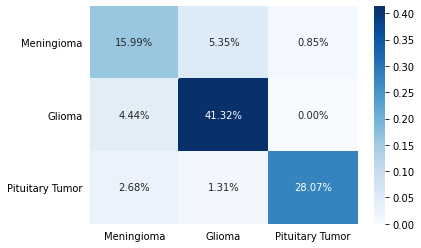

In [114]:
# Percentage of data in each quadrant
categories = ['Meningioma', 'Glioma', 'Pituitary Tumor']
plot = sns.heatmap(confusion_matrix/np.sum(confusion_matrix), xticklabels=categories, yticklabels=categories, annot=True, fmt='.2%', cmap='Blues')
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
plot.tick_params(left=False, bottom=False)